In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import pickle
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
filename ='/content/drive/MyDrive/image_captioning/Flickr8k.token.txt' 
captionsDoc = load_doc(filename)


In [ ]:
def getCaptions(doc):
  mapping=dict()
  for line in doc.split("\n"):
    if len(line)<2:
      continue
    image_id=line.split("\t")[0].split('.')[0]
    caption=line.split("\t")[1]
    if image_id not in mapping:
      mapping[image_id]=[]
    mapping[image_id].append(caption)
  return mapping

captions=getCaptions(captionsDoc)

In [ ]:
import re
#Cleaning of the captions

for id,caption in  captions.items():
  for i in range(len(caption)):
    sentence=caption[i]
    sentence=[word.lower() for word in sentence.split() if len(word)>1]
    sentence=" ".join(sentence)
    sentence=re.sub("[^a-zA-Z]"," ",sentence)
    caption[i]=sentence
    

In [ ]:
captions["401079494_562454c4d6"]

['black and gray dog',
 'two black dogs fight',
 'two black poodles fighting',
 'two black poodles playfully tussle on grassy manicured lawn',
 'two small black dogs facing each other with their mouths open']

In [ ]:
#Let's create corpus_vocabulary
vocabulary=[]
for key,value in captions.items():
  for sentence in value:
      vocabulary.extend(sentence.split())
vocabulary=list(set(vocabulary)) #keeping only unique words
len(vocabulary)

8439

In [ ]:

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	data_captions=[]
	for image_id,capts in descriptions.items():
		for desc in capts:
			data_captions.append(image_id+ ' ' + desc)
	data = '\n'.join(data_captions)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(captions, 'Captions1.txt')

In [ ]:
# Loading train dataset which consist of 6000 images and corresponding captions

def getTrainimageID(filename):
	doc = load_doc(filename)
	image_ids=[]
	for lines in doc.split('\n'):
		if len(lines) < 1:
			continue
		ids = lines.split('.')[0]
		image_ids.append(ids)
	return set(image_ids) # for the purpose of taking unique image ids

# load training dataset (6K)
filename = '/content/drive/MyDrive/image_captioning/Flickr_8k.trainImages.txt'
train = getTrainimageID(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
train

In [ ]:
#Taking path of the images
images = '/content/drive/MyDrive/image_captioning/Images/'
img = glob.glob(images + '*.jpg')

In [ ]:
# Here getting the path of the train images
train_imagess= '/content/drive/MyDrive/image_captioning/Flickr_8k.trainImages.txt'
train_images = set(open(train_imagess, 'r').read().strip().split('\n'))
train_img = [] #storing path of the trainin images
for i in img: 
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i)

In [ ]:
train_img

In [ ]:

test_images_file ='/content/drive/MyDrive/image_captioning/Flickr_8k.testImages.txt'# it stores name of the test images
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = [] # saving test_images_path
for i in img:
    if i[len(images):] in test_images:
        test_img.append(i) 

In [ ]:
def decoder_descriptions(filename, dataset):
  doc = load_doc(filename)
  mapping=dict()
  for line in doc.split("\n"):
    tokens=line.split()

    image_id=tokens[0]
    caption=tokens[1:]
    if image_id in dataset:       
      if image_id not in mapping:
        mapping[image_id]=[]
      desc = 'startseq ' + ' '.join(caption) + ' endseq'  #decoder should contain special tokens during the training
      mapping[image_id].append(desc)
  return mapping

train_descriptions = decoder_descriptions('Captions1.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
####This part is required to be used pretrained image model###
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 2809.9715917110443


In [ ]:
encoding_train

In [ ]:
with open("/content/drive/MyDrive/image_captioning/Images/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)



Time taken in seconds = 512.9018416404724


In [ ]:
with open("/content/drive/MyDrive/image_captioning/Images/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("/content/drive/MyDrive/image_captioning/Images/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Let's find all the train captions 
# We have 6000 train images and each image has 5 descriptions. In total we should have 30000 descriptions
all_train_captions = []
for image, desc in train_descriptions.items():
    for cap in desc:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:

word_threshold = 10 #remove the word from the corpus which occured less than 10
word_counts = {}

for sent in all_train_captions:
    for word in sent.split():
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= word_threshold]
print('preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))

preprocessed words 7334 -> 1658


In [ ]:
# for inputting the sentence to the model we should convert them to the number
# For that reason we created index to word and word to index dictionary
# After training part is  done we should transform  back to the word via ixtoword
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1659

In [ ]:
def max_length(filename):
  sentences=[]
  
  doc = load_doc(filename)
  for sentence in doc.split('\n'):
    #sent=" ".join(sentence.split()[1:])
    sentences.append(sentence.split()[1:])

  lengths=[len(sent) for sent in sentences]
  return max(lengths)+2 # We added 2 to the total.Because in training there are 2 special tokens "startseq"and "endseq"

max_length = max_length('Captions1.txt')
max_length

35

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
#https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926

#
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors
glove_dir = '/content/drive/MyDrive/glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

Found 400000 word vectors.


(1659, 200)

In [ ]:
###  MODEL
# ENCODER-DECODER architecture
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

In [ ]:
# this step is necessary for using pretrained word embeddings
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)           #number_pics_per_bath

# Traning ....
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 519s 86ms/step - loss: 2.4629


In [ ]:
images = '/content/drive/MyDrive/image_captioning/Images/'
with open("/content/drive/MyDrive/image_captioning/Images/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
# Testing our model and generating sentences
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
#### Evaluation Metric####
from nltk.translate.bleu_score import sentence_bleu



def getTestreference(image_id):
  reference_sentences=[]
  for sentence in captions[image_id]:
    reference_sentences.append(sentence.split())
  return reference_sentences

def evaluateBlueScore(image_id,result):
  reference_sentence=getTestreference(image_id)
  candidate=result.split()
  score=sentence_bleu(reference_sentence,candidate)
  return score



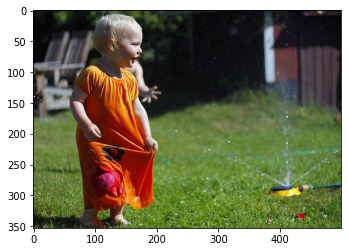

Greedy: boy in blue shirt is playing with toy


LABELS: 
 baby girl in an orange dress gets wet as she stands next to water sprinkler
blonde toddler wearing an orange dress is wet and standing beside sprinkler in yard
child in dress is looking at sprinkler
little girl in an orange dress is running through the sprinkler in the yard
on wet grass little blond girl in orange dress plays in sprinkler
Bleu score 0.7071067811865476





/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


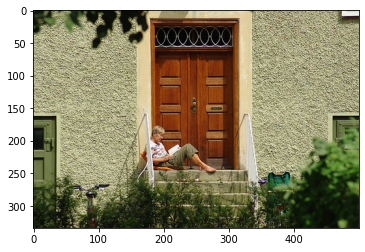

Greedy: man in black shirt is standing by garden


LABELS: 
 lady sitting on front porch reading book
person sits at doorstep and reads book
woman is reading literature and sitting on the front stoop of building
woman sits and reads in the stoop of wooden door
woman sits and reads on the front stoop of her building
Bleu score 0.7071067811865476





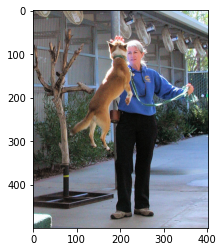

Greedy: two people are sitting on bench


LABELS: 
 dog jumping up to touch woman  s hand
dog jumps to an elderly woman
an airborne dog on leash with woman
the small dog is leaping in the air toward the woman  s hand
the woman in the blue sweater encourages the dog to jump in the air
Bleu score 0.6389431042462724





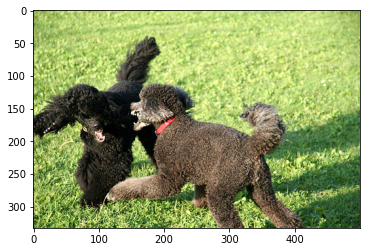

Greedy: dog is running through the grass


LABELS: 
 black and gray dog
two black dogs fight
two black poodles fighting
two black poodles playfully tussle on grassy manicured lawn
two small black dogs facing each other with their mouths open
Bleu score 0.6389431042462724





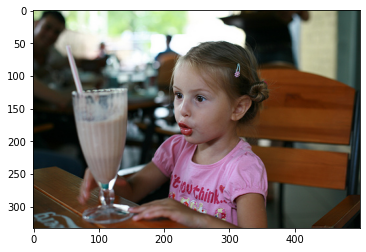

Greedy: the little boy is wearing red shirt and holding an orange


LABELS: 
 little girl wearing pink shirt is sitting at the table and drinking milkshake
small young girl in pink shirt drinking large chocolate milkshake
young girl dressed in pink with hair barrette pursing her lips at big chocolate milkshake
young girl is staring at large milkshake in glass
young girl looks excitedly at large milkshake
Bleu score 0.8593887047640296





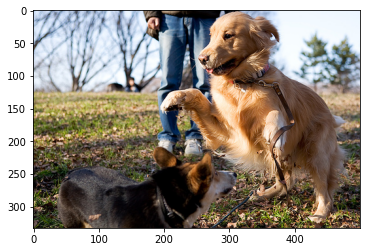

Greedy: two dogs are playing in the grass


LABELS: 
 brown dog about to jump on smaller black and tan dog
large dog playing with smaller dog
two dogs are playing together outside
two dogs playing in the grass with an adult nearby
two dogs playing with each other
Bleu score 0.7952707287670506





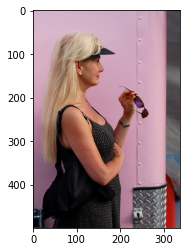

Greedy: woman in black shirt is standing next to woman in black shirt


LABELS: 
 large woman puts her sunglasses on
woman in black dress holding sunglasses
woman wearing black and white outfit while holding her sunglasses
the lady is holding her glasses
the woman with blond hair holds her sunglasses
Bleu score 0.2790159393585827





/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


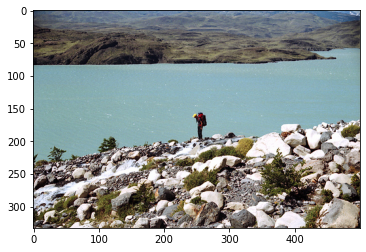

Greedy: man is standing on top of cliff overlooking the ocean


LABELS: 
 man stands alone on the rocks
man stands on rocky cliff overlooking body of water
person is standing on jagged rocks above the water below
person with backpack stands on rocky bank beside body of water
person standing on rocky edge of water with hilly land in background
Bleu score 0.4272870063962341





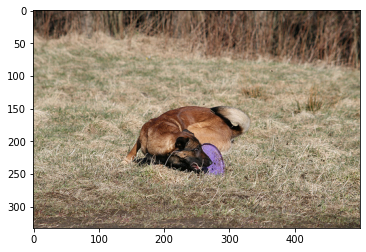

Greedy: two dogs are playing tug of war with green ball


LABELS: 
 brown dog possessively grabs purple frisbee in field
brown dog running to catch frisbee in field of grass
brown dog with purple frisbee in its mouth
dog in field with frisbee
the dog is concerned with purple object lying in an uncut field
Bleu score 0.668740304976422





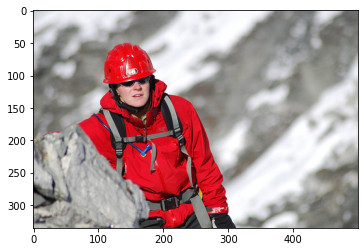

Greedy: man in red shirt and helmet is rock climbing


LABELS: 
 hiker in red on snowy peak
person in red jacket and red hardhat stands near mountain
person wearing red jacket and helmet walks up near the large rock
woman wearing red work man  s hat and red jacket is hiking in the snow topped mountains
the person wearing the red hardhat is on the mountain
Bleu score 0.5942154538528933





/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


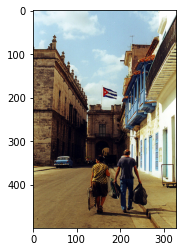

Greedy: man in black shirt is standing by the water


LABELS: 
 couple walking down the street carrying bags
man and woman are carrying bags down an empty street
man and woman walking down street carrying luggage
two people carrying various items walking down city street
two people carry their bags down an unpaved road
Bleu score 0.6865890479690392





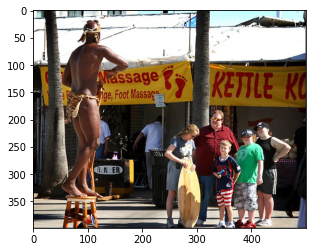

Greedy: two women in black and white wait on the athletic


LABELS: 
 family of five is watching performer standing on stepstool
group of people watch man standing on stool dressed in thong
half naked performer is performing for small crowd outside
man in small bathing suit standing on stool at tourist location
mostly nude man standing on stool while family of look at him questioningly
Bleu score 0.668740304976422





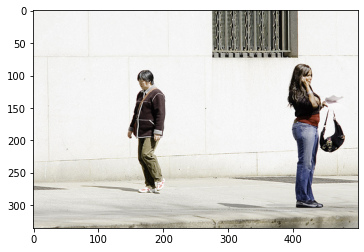

Greedy: woman in black and white skirt walks down the street


LABELS: 
 dark skinned man walks by woman talking on cellphone
male walking and female talking on the phone beside the concrete building
people stand outside near concrete wall and window
two people standing on the sidewalk
two women one carrying purse and papers are standing on sidewalk
Bleu score 0.7952707287670506





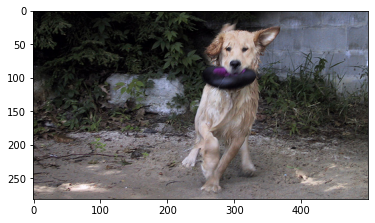

Greedy: dog runs through the water


LABELS: 
 brown dog holding something purple and black in its mouth
dog catches black frisbee
large wet yellow dog retrives his toy
dog running with toy
the wet dog catches toy while playing on the sand
Bleu score 0.7952707287670506





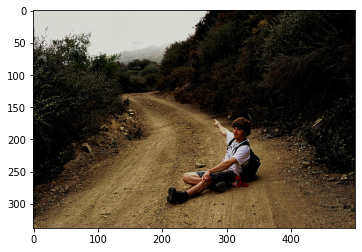

Greedy: man in red shirt is sitting on rock


LABELS: 
 boy pointing in direction on dirt road
boy with backpack sits on trail and points
man points his finger to the path ahead as he sits on the dirt path
man with backpack is sitting in dirt road and pointing toward the horizon
young man sitting in the middle of dirt road pointing up the road
Bleu score 0.5466325569645467





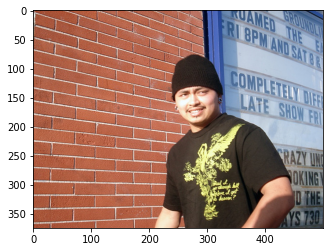

Greedy: man in black shirt and leather jacket stands in front of brick building


LABELS: 
 man in black hat standing in front of brick wall and sign
man in knit cap stands next to brick wall
man standing in front of brick building
man wearing black shirt standing in front of red brick wall
the man in the black hat has his back to theater sign
Bleu score 0.43527713779415106





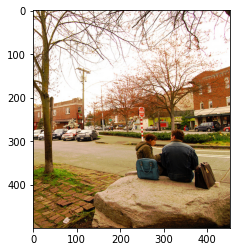

Greedy: man in black shirt is standing by doorway


LABELS: 
 couple are sitting on rock in front of street
man and woman sit on rock beside street
two people sit on large rock near city street
two people sitting on rock in city park
two people talk while sitting on big rock
Bleu score 0.7071067811865476





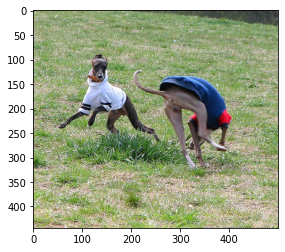

Greedy: black dog is running on the grass


LABELS: 
 the two greyhound dogs wearing sweaters are playing in the grass
two dogs play in the grass
two dogs wearing shirts play in the green grass
two dogs wearing sweaters play in field
two dogs wearing sweaters play in the grass
Bleu score 0.4671379777282001





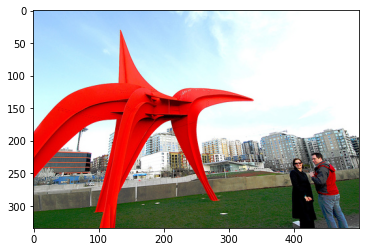

Greedy: two boys are standing on the edge of the bus eating


LABELS: 
 couple looking at red sculpture
man and woman looking at red sculpture
man and woman look back at the camera while standing in front of red art structure
man and woman stand in front of large red modern statue
man and woman stand near large red sculpture outdoors
Bleu score 0.7226568811456053





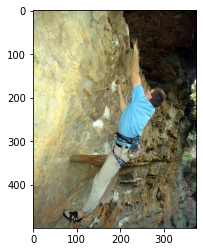

Greedy: man is rock climbing


LABELS: 
 man in blue rock climbing
man wearing glasses is rock climbing
middle aged woman climbs mountain
an adult wearing harness climbs in rocky area
person in blue shirt scales wall
Bleu score 0.5917606269910581





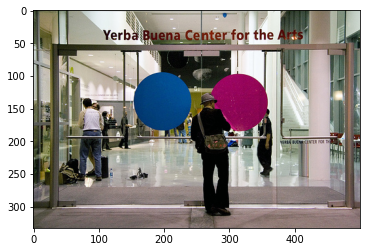

Greedy: man in black shirt and cap is standing next to woman in black shirt


LABELS: 
 man is standing in front of glass doors with blue spot and pink spot
man is standing outside the glass doors of an art center
man stands at the entrance of yerba buena center for the arts
man walking through glass double doors
person standing at glass doors with big blue circle and big pink circle
Bleu score 0.4071220775553065





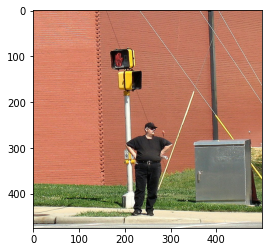

Greedy: two men are standing on the edge of the road listening


LABELS: 
 large man dressed in black on street corner by red brick building
man dressed in black is waiting at crosswalk
man dressed in black stands at street corner near crossing light
man stands at traffic light waiting to cross the street
man in black waits at crossing signal near large brick building
Bleu score 0.6529942057256104





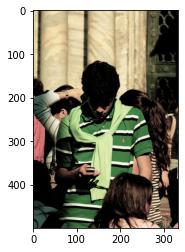

Greedy: man in black shirt is standing in front of crowd


LABELS: 
 dark skinned man in green shirt with green scarf looking at an electronic device
man in green shirt and sweater looks at his cellphone
man wearing green shirt looks down at cellphone
teenager standing in crowd of people texting on his phone
man with green shirt looks at phone
Bleu score 0.6042750794713536





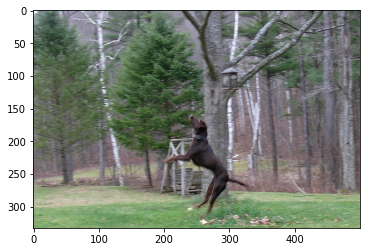

Greedy: dog runs through the woods


LABELS: 
 black dog jumping
brown dog is jumping on its hind legs
brown dog is leaping into the air in front of wooden structure in pine forest
brown dog jumping off the ground in the woods
the dog leaps into the air in field
Bleu score 0.6223329772884784





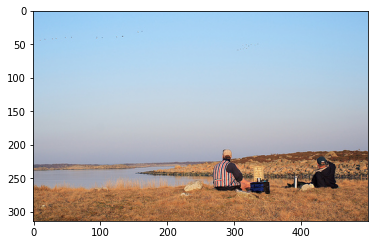

Greedy: man is standing on top of rock overlooking the ocean


LABELS: 
 two men sitting on the bank of lake with an ice chest
two people having picnic by lake
two people having picnic by the shore
two people sitting on grass in front of lake looking at the sky
two people with hats looking at lake while sitting on yellow grassed hill
Bleu score 0.6059285518620335





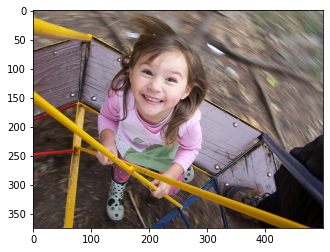

Greedy: young boy in red shirt is swinging on the bed


LABELS: 
 little girl gets her picture taken while on the merry go round
little girl in pink clothes holding yellow rods
little girl on piece of playground equipment
little girl sitting on playground ride
young girl looks up as she rides on merry go round
Bleu score 0.41545589177443254





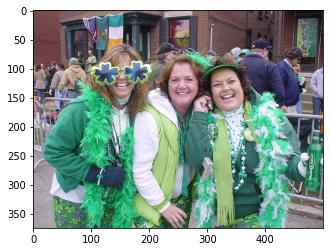

Greedy: woman in pink hooded sweatshirt stands in crowd


LABELS: 
 there are women in st patrick  s day costumes
three women celebrate st patrick  s day by dressing up in green and white on busy street
three women dressed in green celebrating st patricks day
three women dressed up in green and shamrocks
three women wearing plenty of green and shamrocks
Bleu score 0.5946035575013605





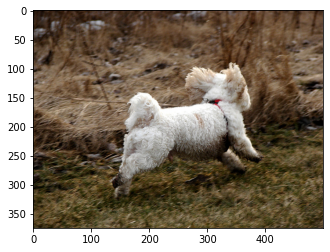

Greedy: white dog is running through the grass


LABELS: 
 fluffy white dog runs through the woods with his ears flapping in the breeze
small white dog is running across grassy field
white dog runs in the grass
white dog wearing red harness runs though the woods
the little white dog wearing the red collar is running in the grass
Bleu score 0.537284965911771





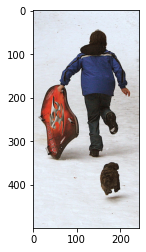

Greedy: two children play in the snow


LABELS: 
 boy drags his sled through the snow
boy in blue jacket carrying red sled running away followed by small dog
child running with snowboard on snow covered surface
child wearing blue coat runs along the snow while small dog follows
young boy plays with his dog in the snow
Bleu score 0.40027649424491646





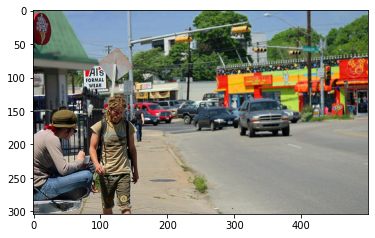

Greedy: man in black shirt and jeans stands in front of bus


LABELS: 
 man sitting on the left near man walking along the side of street with colorful buildings
man walking by sitting man on the street
man with dreadlocks and backpack walks down the sidewalk with colorful buildings in the background
white man with dreadlocks walks down the sidewalk
two boys are on the sidewalk as cars pass by on the road
Bleu score 0.6474469561695607





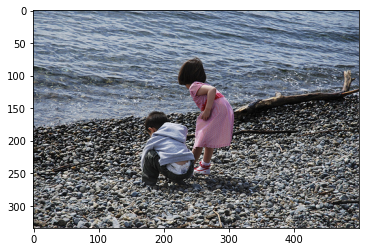

Greedy: two girls stand on rocky shoreline


LABELS: 
 little boy and little girl are playing with pebbles on the beach
small boy and girl on the beach  s edge looking at the ground
two kids playing on pebble beach by the water
two little kids play on pebble covered beach
two young child stand on the rocks near the edge of the water
Bleu score 0.40293516672844226





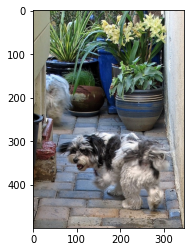

Greedy: dog is biting the ear of another dog


LABELS: 
 black and white dog is running up path towards some potted plants
dog follows another dog around the corner but looks back
dog is turns back toward the camera near some potted plants
dog turning to look at the camera
white and black dog in hallway filled with potted plants
Bleu score 0.6500593260343691





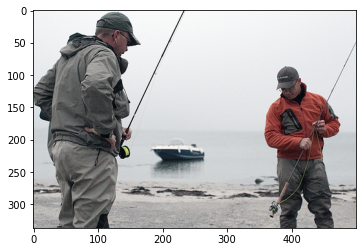

Greedy: man in red shirt is standing on rock


LABELS: 
 men standing on shore with fishing pole and boat in water
two fisherman looking at the water
two men holding their fishing poles
two men stand near the water with their fishing poles
two men with fishing rods are standing on shore
Bleu score 0.42456725576936255





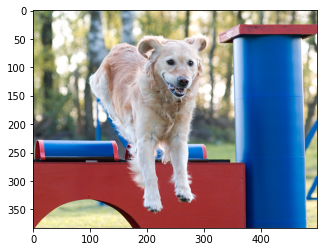

Greedy: dog is jumping over log


LABELS: 
 dog is jumping across an obstacle
dog jumps over red and blue hurdle
dog leaps over red and blue jump
golden retreiver jumps over an obstacle
tan dog jumping over red and blue toy
Bleu score 0.5475182535069453





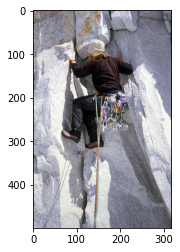

Greedy: man in red jacket is standing on the sidewalk next to building


LABELS: 
 girl is climbing rock wall
person climbs steep mountain
person wearing white hat climbs rock
rock climber ascends
someone climbs rocks
Bleu score 0.537284965911771





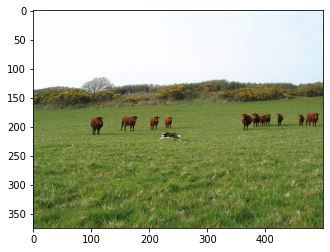

Greedy: group of people are standing in the grass with their dogs


LABELS: 
 black and white dog is running through cow field
black and white dog running in the grass where there are some cows
calf is running in the fields while cows look on
cow herd grazing in the pasture with dog running in the foreground
dog running in the grass around sheep
Bleu score 0.31702331385234306





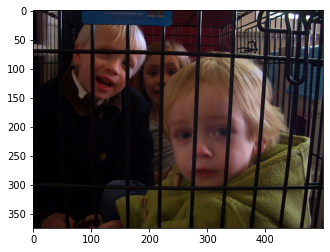

Greedy: two boys are eating


LABELS: 
 the three children are in cage
three children are locked in cage
three children in black dog kennel
three small children are in cage
three well dressed blond children in cage
Bleu score 0.42888194248035344





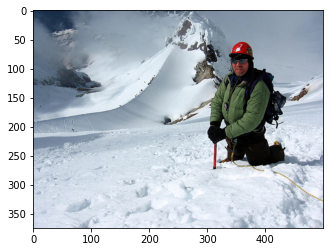

Greedy: skier is descending down snowy mountain


LABELS: 
 man crouched on snowy peak
man in green jacket stands in deep snow at the base of mountain
man kneels in the snow
man measures the depth of snow
mountain hiker is digging steaks into the thck snow
Bleu score 0.8408964152537145





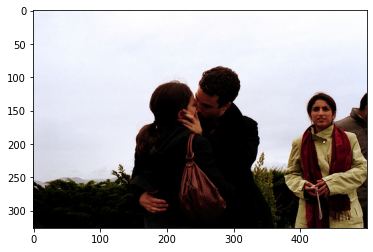

Greedy: man in leather jacket stands in front of mountain


LABELS: 
 couple kiss outdoors while another couple watch
man and woman are outside kissing with woman wearing red scarf in the background
the woman on the right is wearing red scarf
two people in complete love are kissing in the most beautiful embrace
two people kissing
Bleu score 0.7598356856515925





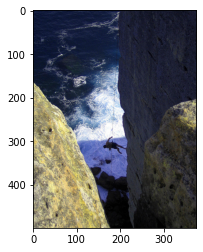

Greedy: man is standing on top of rock overlooking the ocean


LABELS: 
 man repels down cliff over water
mountain climber hangs from cliff above the ocean
person descends rope from cliff into the ocean
person is climbing cliff wall over rocky shore using rope
the man is climbing up the rock
Bleu score 0.5773502691896257





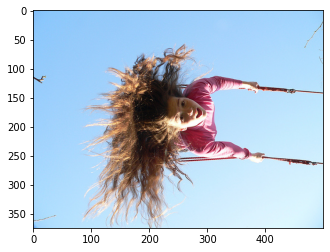

Greedy: child in red shirt is bungee on the tail of an inflatable slide


LABELS: 
 girl in pink top is swinging with her hair flying everywhere
girl is swinging
girl is swinging and looking down with her hair flying
girl  s hair streams behind her as she swings
girl with long hair flying in the breeze while she swings
Bleu score 0.6930977286178778





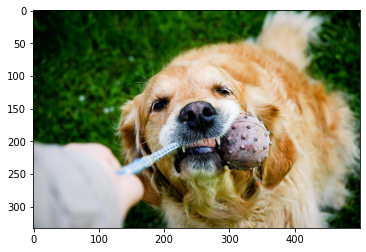

Greedy: dog is shaking off water from its fur


LABELS: 
 dog bites an object offered by person
dog playing with dog toy as someone tries to pull it from its mouth
golden retriever plays with toy
the photographer is playing tug of war with dog
two dogs fighting for the same chew toy
Bleu score 0.5169731539571706





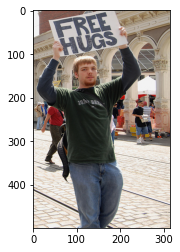

Greedy: man in black shirt is standing next to building


LABELS: 
 man carrying sign that says free hug along the sidewalk
man holds up free hugs sign above his head
man is holding sign that says free hugs
young man in black shirt is holding free hugs sign
the man is wearing green shirt and blue jeans and carrying free hugs sign
Bleu score 0.44632361378533286





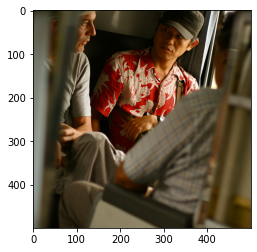

Greedy: man in black shirt is sitting on bus


LABELS: 
 man with red shirt and black hat stares at another man
asian man in red flowered shirt and hat in discussion with two other men
talk between man in hawaiian shirt older man in gray and man seen from behind
these three men are sitting near each other and are all wearing short sleeved shirts
three men one in red and white shirt are sitting together
Bleu score 0.37569469583982834





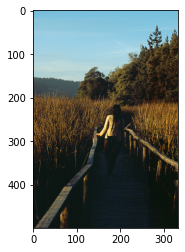

Greedy: man in red shirt is standing on top of ridge


LABELS: 
 woman is walking away on wooden walkway through field of golden plants
woman walking over bridge with tall grass on either side of her
woman walks along boardwalk
woman with dark hair walks through grassy field on path with wooden handrails
young woman crosses bridge through field of tall grass
Bleu score 0.7400828044922853





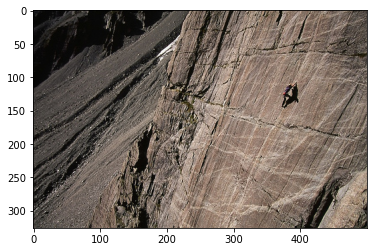

Greedy: man is standing on top of mountain


LABELS: 
 distant person is climbing up very sheer mountain
panoramic distance view of rock climber going up steep mountain wall
person rock climbing
there is person scaling very steep rock wall
this person is climbing the side of mountain
Bleu score 0.44815260192961937





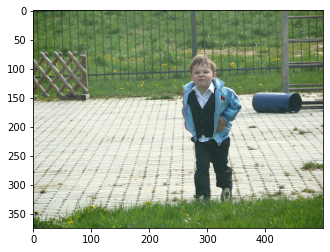

Greedy: man in black shirt is standing next to building


LABELS: 
 child in formal clothing is walking along the edge of stony area that is littered in places
little boy with blue jacket is making sour face at the camera
young boy wearing light blue jacket walks across the brick patio
young boy with blue coat makes funny face as he walks towards the grass
the young boy is walking wearing blue jacket black sweater and white collared shirt
Bleu score 0.6537993517025207





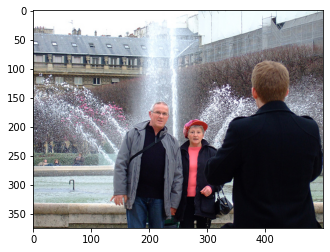

Greedy: two men are standing on the ground next to the water


LABELS: 
 couple is photographed in front of large outdoor fountain
couple pose in front of fountain
an older couple posing in front of fountain for picture
older couple posing for picture in front of fountain
the parents of the younger male are posing for picture in front of water fountain
Bleu score 0.7765453555044466





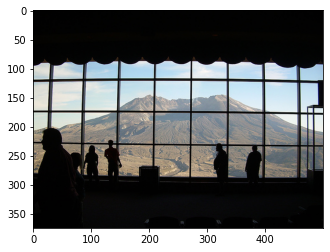

Greedy: man in red shirt is standing by the water


LABELS: 
 group of people inside building that overlooks large mountain
large window with mountain range while onlookers stand in front
people look out the window at mountains
people stand and look out the window to view the mountain
sillhouttes of people in front of mountain and in front of window
Bleu score 0.6865890479690392





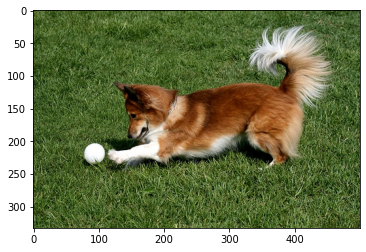

Greedy: dog is running through the grass


LABELS: 
 brown and white dog chasing ball on some grass
brown and white dog has is playing with white ball on the grass
collie plays with white ball in field of green grass
orange dog playing with white ball on green grass
small brown dog paws at white ball
Bleu score 0.5115078115793242





In [ ]:

for i in range(50):
  
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1,2048))
  img_id=list(encoding_test.keys())[i].split('.')[0]
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  prediction=greedySearch(image)
  print("Greedy:",prediction)
  print("\n")
  print("LABELS:","\n","\n".join(captions[img_id]))
  print("Bleu score",evaluateBlueScore(img_id,prediction))
  print('\n'*2)

# CONTINUATION WITH GPT-2

In [ ]:
%tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

In [ ]:
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 364Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 3.26Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 327Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:15, 31.5Mit/s]
Fetching model.ckpt.index: 1.05Mit [00:00, 358Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 4.23Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 4.12Mit/s]


In [ ]:
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset='/content/drive/MyDrive/bookss.txt',
              model_name='124M',
              steps=1000,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=500
              )

In [ ]:
gpt2.generate(sess,
              length=50,
              temperature=0.7,
              prefix="man in red shirt is sitting on bench next to building",
              nsamples=5,
              batch_size=5
              )

man in red shirt is sitting on bench next to building.



p46e.jpg (53K)



CHAPTER XLVII.
OF WHAT HAPPENED DON QUIXOTE ON HIS WAY TO SEE HIS DEED
OF A DON QUIXOTE LETTER
man in red shirt is sitting on bench next to building-place
door, and his curls are hanging on a string, and he will die
at once if he does not know how.”

“What!”

“Dost thou see, Sancho,
man in red shirt is sitting on bench next to building
floor. He is in his pajamas. He has a book in his lap. He is dressed in
a yellow turban, a tight-fitting dark doublet with red and gold trim
and a gold and silver cuff. He
man in red shirt is sitting on bench next to building
tower in
Don Quixote’s house; and all the time he has not been there in
his life, and will never be there in his death.”

“Nay, Sancho,”
man in red shirt is sitting on bench next to building-place. He is
green-crested, and he has a big smile on his face. He has a good
air of grey, and his shoulders are square. He has a touch of yellow in
his eye.




In [ ]:
gpt2.generate(sess,  
              prefix="two dogs are running through the grass",
              length=40,
              temperature=0.7,
              top_p=0.9,
              nsamples=5,
              batch_size=5
              )

two dogs are running through the grass
round the corner.”

“So, so,” said the curate, “there’s three of us.”

“I don
two dogs are running through the grass
through the door.”

“What are dogs?”

“They are cats that are playing in the grass.”

“They are.
two dogs are running through the grass,
and that the common people will not let them come out.”

“I am afraid,” said Sancho, “that the good people will not let

two dogs are running through the grass.”

“I am afraid so,” said Sancho. “I have heard say that in
the village there is a fire-house where they burn the dead
two dogs are running through the grass, and I am taking
out my
wine-skins.”

“You are wrong, Sancho,” said Don Quixote; “for my master


REFERENCES

good use-case
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb 

higly adopted approach for image captioning
https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

GPT-2
https://medium.com/the-research-nest/practical-applications-of-open-ais-gpt-2-deep-learning-model-14701f18a432